In [2]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [3]:
import numpy as np
import pandas as pd

In [4]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [5]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [6]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [7]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [8]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [9]:
# Save references to each table
Measure = Base.classes.measurement
Station = Base.classes.station

In [10]:
# Create our session (link) from Python to the DB
session = Session(engine)

In [19]:
inspector = inspect(engine)
columns = inspector.get_columns('measurement')
for c in columns:
    print(c['name'], c['type'])
    

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [22]:
engine.execute('SELECT * FROM measurement LIMIT 3').fetchall()

[(1, 'USC00519397', '2010-01-01', 0.08, 65.0),
 (2, 'USC00519397', '2010-01-02', 0.0, 63.0),
 (3, 'USC00519397', '2010-01-03', 0.0, 74.0)]

In [23]:
columns = inspector.get_columns('station')
for c in columns:
    print(c['name'], c["type"])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [24]:
engine.execute('SELECT * FROM station LIMIT 3').fetchall()

[(1, 'USC00519397', 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0),
 (2, 'USC00513117', 'KANEOHE 838.1, HI US', 21.4234, -157.8015, 14.6),
 (3, 'USC00514830', 'KUALOA RANCH HEADQUARTERS 886.9, HI US', 21.5213, -157.8374, 7.0)]

# Exploratory Climate Analysis

In [25]:
latest = session.query(Measure.date).\
    order_by(Measure.date.desc()).first()
latest


('2017-08-23')

In [72]:
year_before = dt.date(2017,8,23) - dt.timedelta(days=365)
year_before

datetime.date(2016, 8, 23)

In [73]:
# Perform a query to retrieve the data and precipitation scores
year_prior = session.query(Measure.date, Measure.prcp).\
    filter(Measure.date >= '2016-08-23', Measure.date <= '2017-08-23').\
        order_by(Measure.date).all()
year_prior


[('2016-08-23', 0.0),
 ('2016-08-23', 0.15),
 ('2016-08-23', 0.05),
 ('2016-08-23', None),
 ('2016-08-23', 0.02),
 ('2016-08-23', 1.79),
 ('2016-08-23', 0.7),
 ('2016-08-24', 0.08),
 ('2016-08-24', 2.15),
 ('2016-08-24', 2.28),
 ('2016-08-24', None),
 ('2016-08-24', 1.22),
 ('2016-08-24', 2.15),
 ('2016-08-24', 1.45),
 ('2016-08-25', 0.08),
 ('2016-08-25', 0.08),
 ('2016-08-25', 0.0),
 ('2016-08-25', 0.0),
 ('2016-08-25', 0.21),
 ('2016-08-25', 0.06),
 ('2016-08-25', 0.11),
 ('2016-08-26', 0.0),
 ('2016-08-26', 0.03),
 ('2016-08-26', 0.02),
 ('2016-08-26', 0.04),
 ('2016-08-26', 0.0),
 ('2016-08-26', 0.01),
 ('2016-08-27', 0.0),
 ('2016-08-27', 0.18),
 ('2016-08-27', 0.02),
 ('2016-08-27', 0.0),
 ('2016-08-27', 0.12),
 ('2016-08-27', None),
 ('2016-08-28', 0.01),
 ('2016-08-28', 0.14),
 ('2016-08-28', 0.14),
 ('2016-08-28', 0.14),
 ('2016-08-28', 0.6),
 ('2016-08-28', 2.07),
 ('2016-08-29', 0.0),
 ('2016-08-29', 0.17),
 ('2016-08-29', 0.04),
 ('2016-08-29', None),
 ('2016-08-29', 0.0),

In [74]:
# Save the query results as a Pandas DataFrame and set the index to the date column
rain_df = pd.DataFrame(year_prior, columns=['Date', 'Precipitation'])
rain_df.set_index('Date', inplace=True)

# Sort the dataframe by date
rain_df = rain_df.sort_index(ascending=True)
rain_df

,Precipitation
Date,
2016-08-23,0.00
2016-08-23,0.15
2016-08-23,0.05
2016-08-23,NaN
2016-08-23,0.02
...,...
2017-08-22,0.50
2017-08-23,0.00
2017-08-23,0.00


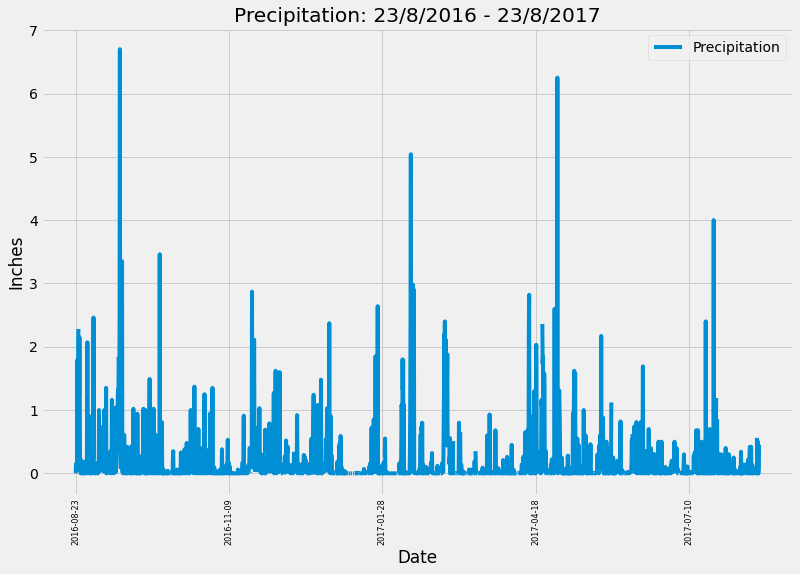

In [75]:
# Use Pandas Plotting with Matplotlib to plot the data
ax = rain_df.plot(figsize=(12, 8))
plt.title("Precipitation: 23/8/2016 - 23/8/2017")
plt.ylabel("Inches")
plt.xticks(rotation=90, size=8)
plt.savefig("../sqlalchemy-challenge/Precip.png")
plt.show()


In [76]:
# Use Pandas to calcualte the summary statistics for the precipitation data
rain_df.describe()

,Precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [77]:
# Design a query to show how many stations are available in this dataset?
session.query(Station.id).count()

9

In [78]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
act_stat = session.query(Measure.station, func.count(Measure.station)).\
    group_by(Measure.station).order_by(func.count(Measure.station).desc()).all()
act_stat


[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [79]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?
best_stat = act_stat[0][0]
session.query(func.min(Measure.tobs), func.avg(Measure.tobs), func.max(Measure.tobs)).\
    filter(Measure.station == best_stat).all()

[(54.0, 71.66378066378067, 85.0)]

In [82]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
temp_results = session.query(Measure.station, Measure.tobs).\
    filter(Measure.station == best_stat).\
        filter(Measure.date >= year_before).all()
temp_obs_df = pd.DataFrame(temp_results)
temp_obs_df.set_index('station', inplace=True)
temp_obs_df.head(3)

,tobs
station,
USC00519281,77.0
USC00519281,77.0
USC00519281,80.0


<function matplotlib.pyplot.show(close=None, block=None)>

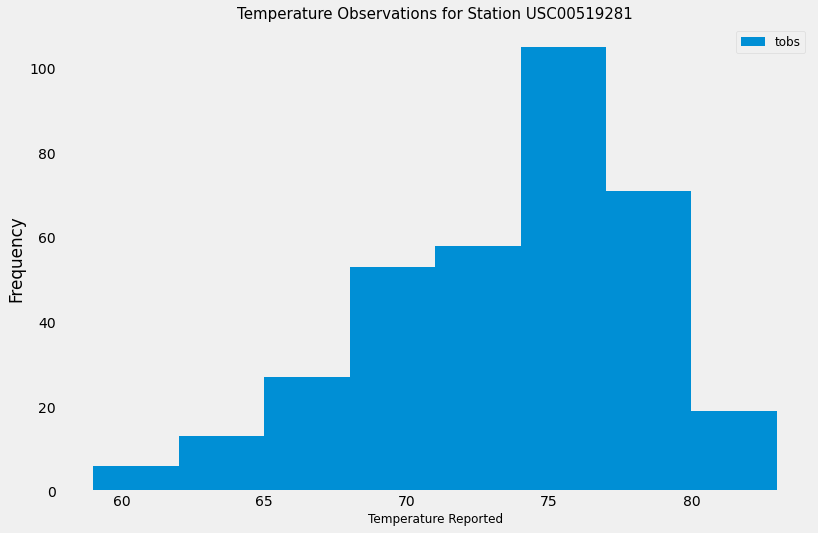

In [84]:
# Plot Histogram
temp_obs_df.plot.hist(by='station', bins=8, figsize=(12,8))
plt.grid()
plt.title("Temperature Observations for Station " + best_stat, fontsize=15)
plt.xlabel("Temperature Reported", fontsize=12)
plt.legend(bbox_to_anchor=(1,1), fontsize=12)
plt.savefig("../sqlalchemy-challenge/StationTemps.png")
plt.show


## Bonus Challenge Assignment

In [93]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measure.tobs), func.avg(Measure.tobs), func.max(Measure.tobs)).\
        filter(Measure.date >= start_date).filter(Measure.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [94]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
temps = calc_temps('2011-02-28', '2011-03-05')
temps

[(61.0, 69.75510204081633, 75.0)]

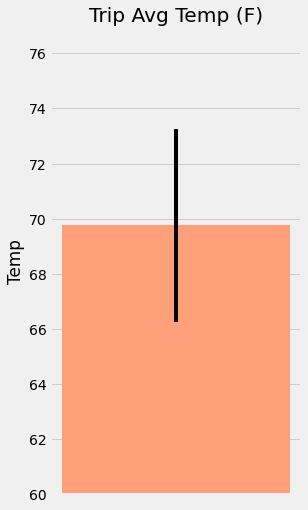

In [104]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
lower = temps[0][1] - temps[0][0]
upper = temps[0][2] - temps[0][1]
plt.figure(figsize=(4,8))
plt.bar(0, temps[0][1], yerr=[upper-lower], color='lightsalmon')
plt.title("Trip Avg Temp (F)")
plt.xticks([])
plt.ylabel("Temp")
plt.ylim(60)
plt.savefig("../sqlalchemy-challenge/Trip_Avg_Tamp.png")
plt.show()


In [118]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation
def rainfall(start_date, end_date):
    return session.query(Measure.station, Station.name, Measure.prcp.label('rainfall'),
    Station.latitude, Station.longitude, Station.elevation).\
        group_by(Measure.station).\
            join(Station, Measure.station == Station.station).\
                filter(Measure.date >= start_date).\
                    filter(Measure.date <= end_date).\
                        order_by(func.sum(Measure.prcp).desc()).all()

rainfall('2011-02-28', '2011-03-05')

[('USC00518838',
  'UPPER WAHIAWA 874.3, HI US',
  None,
  21.4992,
  -158.0111,
  306.6),
 ('USC00519281',
  'WAIHEE 837.5, HI US',
  0.0,
  21.45167,
  -157.84888999999998,
  32.9),
 ('USC00519523',
  'WAIMANALO EXPERIMENTAL FARM, HI US',
  0.02,
  21.33556,
  -157.71139,
  19.5),
 ('USC00514830',
  'KUALOA RANCH HEADQUARTERS 886.9, HI US',
  None,
  21.5213,
  -157.8374,
  7.0),
 ('USC00516128',
  'MANOA LYON ARBO 785.2, HI US',
  0.0,
  21.3331,
  -157.8025,
  152.4),
 ('USC00513117', 'KANEOHE 838.1, HI US', 0.0, 21.4234, -157.8015, 14.6),
 ('USC00519397', 'WAIKIKI 717.2, HI US', 0.0, 21.2716, -157.8168, 3.0),
 ('USC00511918',
  'HONOLULU OBSERVATORY 702.2, HI US',
  0.0,
  21.3152,
  -157.9992,
  0.9),
 ('USC00517948', 'PEARL CITY, HI US', None, 21.3934, -157.9751, 11.9)]

In [119]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measure.tobs), func.avg(Measure.tobs), func.max(Measure.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measure.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [127]:
# calculate the daily normals for your trip
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`
# Set the start and end date of the trip
# Use the start and end date to create a range of dates
# Stip off the year and save a list of %m-%d strings
# Loop through the list of %m-%d strings and calculate the normals for each date
#('2011-02-05', '2011-02-20')
trip_start = dt.date(2011,2,5)
trip_end = dt.date(2011,2,20)

In [128]:
def daily_normals(day_date):
    norm_temps = session.query(func.min(Measure.tobs), func.avg(Measure.tobs),
    func.max(Measure.tobs)).filter(func.strftime("%m-%d", Measure.date) == day_date).all()

    return norm_temps

dates = pd.date_range(trip_start, trip_end)
trip_mmdd = dates.strftime('%m-%d')

norm_list = []
for trip_date in trip_mmdd:
    norm_list.append(*daily_normals(trip_date))

trip_norm_df = pd.DataFrame(norm_list, columns=['Tmin', 'Tavg', 'Tmax'])
trip_norm_df['Date'] = dates
trip_norm_df = trip_norm_df.set_index('Date')


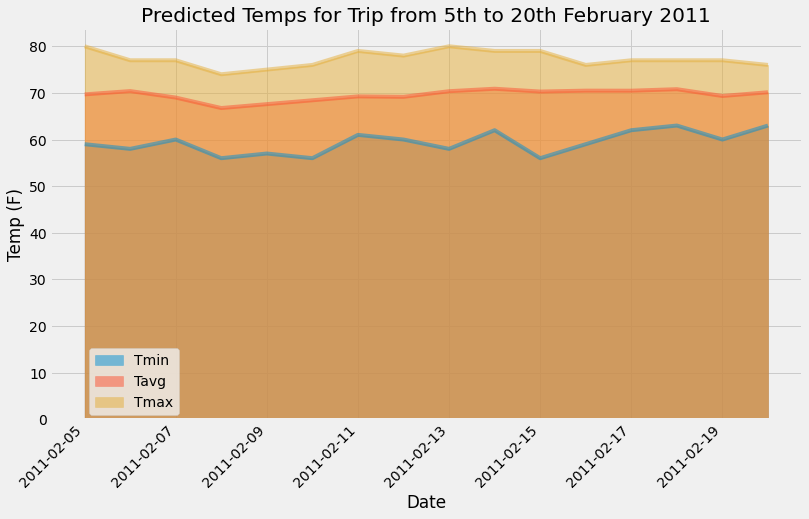

In [145]:
# PLot
colours = ['skyblue', 'sandybrown', 'lemonchiffon']
trip_norm_df.plot(kind='area', title="Predicted Temps for Trip from 5th to 20th February 2011",
         figsize=(12,8), stacked=False, x_compat=True, rot=45)
plt.ylabel('Temp (F)')
plt.legend(bbox_to_anchor = [0.18, 0.2])
plt.savefig("../sqlalchemy-challenge/Area_plot.png")
plt.show()

In [ ]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index


In [ ]:
# Plot the daily normals as an area plot with `stacked=False`
